## CNN Tensorflow

Build and train a Convolutional Neural Network in TensorFlow for a classification problem 

In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from cnn_utils import *
import joblib
import os

%matplotlib inline
np.random.seed(1)

In [2]:
tf.__version__

'1.10.0'

In [3]:
# Load the dataset
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

y = 2


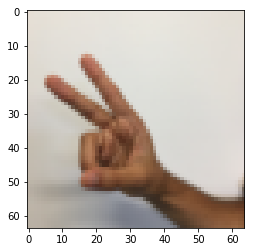

In [4]:
# Example of a picture
index = 6
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [5]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


#### Create Placeholders

In [6]:
def create_placeholders(nh, nw, nc, ny):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    nh -- scalar, height of an input image
    nw -- scalar, width of an input image
    nc -- scalar, number of channels of the input
    ny -- scalar, number of classes
        
    Returns:
    X -- placeholder for the data input, of shape [None, nh, nw, nc] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, ny] and dtype "float"
    """
    
    X = tf.placeholder(tf.float32, shape=(None, nh, nw, nc))
    Y = tf.placeholder(tf.float32, shape=(None, ny))
    
    return X, Y

In [7]:
X, Y = create_placeholders(64, 64, 3, 6)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("Placeholder:0", shape=(?, 64, 64, 3), dtype=float32)
Y = Tensor("Placeholder_1:0", shape=(?, 6), dtype=float32)


### Initialize parameters

In [80]:
def initialize_parameters():
    """
    Initializes Filters and Weight parameters to build a neural network with tensorflow. The shapes are:
                        F1 = W1 : [3, 3, 3, 16]
                        F2 = W2 : [3, 3, 16, 8]
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """
    
    tf.set_random_seed(1)
    
    W1 = tf.get_variable("W1", shape=(3, 3, 3, 8), initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2", shape=(3, 3, 8, 32), initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W3 = tf.get_variable("W3", shape=(256, 2048), initializer=tf.contrib.layers.xavier_initializer(seed=0))
    b3 = tf.get_variable("b3", shape=(256, 1), initializer=tf.zeros_initializer())
    W4 = tf.get_variable("W4", shape=(6, 256), initializer=tf.contrib.layers.xavier_initializer(seed=0))
    b4 = tf.get_variable("b4", shape=(6, 1), initializer=tf.zeros_initializer())
    
    parameters = {
        "W1" : W1,
        "W2" : W2,
        "W3" : W3,
        "b3" : b3,
        "W4" : W4,
        "b4" : b4
    }
    
    return parameters

In [81]:
tf.reset_default_graph()

with tf.Session() as test_sess:
    parameters = initialize_parameters()
    init = tf.global_variables_initializer()
    test_sess.run(init)
    print("The shapes of parameters: ")
    print("W1 = " + str(parameters["W1"].shape))
    print("W2 = " + str(parameters["W2"].shape))
    print("W3 = " + str(parameters["W3"].shape))
    print("b3 = " + str(parameters["b3"].shape))
    print("W4 = " + str(parameters["W4"].shape))
    print("b4 = " + str(parameters["b4"].shape))
    

The shapes of parameters: 
W1 = (3, 3, 3, 8)
W2 = (3, 3, 8, 32)
W3 = (256, 2048)
b3 = (256, 1)
W4 = (6, 256)
b4 = (6, 1)


### Forward propagation

In [82]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FC(256 UNITS) -> RELU -> DROPOUT -> FC(6 UNITS)
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2", "W3", "b3", "W4", "b4"
                  the shapes are given in initialize_parameters

    Returns:
    Z4 -- the output of the last LINEAR unit
    """
    
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    W4 = parameters["W4"]
    b4 = parameters["b4"]
    
    # First Convolutional Layer + Maxpool
    Z1 = tf.nn.conv2d(X, W1, strides=[1,1,1,1], padding="SAME")
    A1 = tf.nn.relu(Z1)
    A1 = tf.nn.max_pool(A1, ksize=[1,4,4,1], strides=[1,4,4,1], padding="SAME")
    
    # Second Convolutional Layer + Maxpool
    Z2 = tf.nn.conv2d(A1, W2, strides=[1,1,1,1], padding="SAME")
    A2 = tf.nn.relu(Z2)
    A2 = tf.nn.max_pool(A2, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")
    
    # Flatten
    A2 = tf.contrib.layers.flatten(A2)
    
    # Fully Connected layer with dropout 
    # Input shapes: A2 - (m, 2048) W3 - (256, 2048) b3 - (256, 1); Output shape: A3 - (m, 256)
    Z3 = tf.add(tf.matmul(A2, tf.transpose(W3)), tf.transpose(b3)) 
    A3 = tf.nn.relu(Z3)
    A3 = tf.nn.dropout(A3, 0.5)
    
    # Fully Connected layer without activation - Logits
    # Input shapes: A3 - (m, 256) W4 - (6, 256), b4 - (6, 1); Output shape: Z4 - (m, 6)
    Z4 = tf.add(tf.matmul(A3, tf.transpose(W4)), tf.transpose(b4))
    
    return Z4

In [83]:
tf.reset_default_graph()

with tf.Session() as test_sess:
    np.random.seed(1)
    X, Y = create_placeholders(64, 64, 3, 6)
    parameters = initialize_parameters()
    Z4 = forward_propagation(X, parameters)
    init = tf.global_variables_initializer()
    test_sess.run(init)
    a = test_sess.run(Z4, feed_dict={X: np.random.randn(2,64,64,3),
                                     Y: np.random.randn(2,6)})
    print("Z4 = " + str(a))

Z4 = [[ 1.4020364   0.08449285  0.30149716  0.5080071  -2.2559445   1.2798958 ]
 [ 0.6930938  -1.0082471  -3.0650344   0.42669046 -2.5822346   0.9189383 ]]


### Compute cost

In [12]:
def compute_cost(Z4, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    cost = tf.nn.softmax_cross_entropy_with_logits(logits=Z4, labels=Y)
    return tf.reduce_mean(cost)

In [13]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(64, 64, 3, 6)
    parameters = initialize_parameters()
    Z4 = forward_propagation(X, parameters)
    cost = compute_cost(Z4, Y)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(cost, {X: np.random.randn(4,64,64,3), Y: np.random.randn(4,6)})
    print("cost = " + str(a))


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

cost = -2.1304715


### Model - Stitching the pieces together

The model below should:

    create placeholders 
    initialize parameters 
    forward propagate 
    compute the cost 
    create an optimizer 


In [86]:
def model(X_train, y_train, X_test, y_test, alpha=0.009, epochs=100, batch_size=64, verbose=True):
    """
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FC(128 UNITS) -> RELU -> DROPOUT -> FC(6 UNITS)
    Arguments:
    X_train -- training set, of shape (None, 64, 64, 3)
    y_train -- test set, of shape (None, n_y = 6)
    X_test -- training set, of shape (None, 64, 64, 3)
    y_test -- test set, of shape (None, n_y = 6)
    alpha -- learning rate of the optimization
    epochs -- number of epochs of the optimization loop
    batch_size -- size of a minibatch
    verbose -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()
    tf.set_random_seed(1)
    costs = []
    
    # Get the shapes to create the placeholders
    m, nh, nw, nc = X_train.shape
    m, ny = y_train.shape
    
    # Create Placeholders
    X, y = create_placeholders(nh, nw, nc, ny)
    
    # Initialize the parameters and filters W1 - (3,3,3,8) W2 - (3,3,8,32)
    parameters = initialize_parameters()
    
    # Compute Z3 Conv2d -> ReLU -> Maxpool -> Conv2d -> ReLU -> Maxpool -> Flatten -> FC(256 units) -> FC(6 units)
    Z4 = forward_propagation(X, parameters)
    
    # Compute cost as tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(Z3,y))
    cost = compute_cost(Z4, y)
    
    # Back propagate the cost as tf.train.AdamOptimizer(alpha).minimize(cost)
    optimizer = tf.train.AdamOptimizer(learning_rate=alpha).minimize(cost)
    
    # Initiate a session
    with tf.Session() as sess:
        
        # Initialize global variables
        init = tf.global_variables_initializer()
        sess.run(init)
        
        # Iterate over epochs
        for epoch in range(epochs + 1):
            
            # total number of mini batches = total examples/mini batch size
            t_minibatches = math.ceil(m / batch_size)
            
            # Generate random mini batches from X_train and y_train
            minibatches = random_mini_batches(X_train, y_train, batch_size, seed=3)
            
            # Set initial cost of the current epoch to 0
            epoch_cost = 0.
            
            # Loop over the minibatches                        
            for minibatch in minibatches:
                
                mini_X, mini_Y = minibatch
                
                # Compute mini batch cost by feeding mini batch X and mini batch Y to the cost expression
                minibatch_cost = sess.run(cost, feed_dict={X : mini_X,
                                                           y : mini_Y})
                
                # Run backpropagation by feeding mini batch X and mini batch Y to the optimizer expression
                _ = sess.run(optimizer, feed_dict={X : mini_X,
                                                   y : mini_Y})
                
                # Update the mini batch cost
                epoch_cost += minibatch_cost
                
            # Calculate the epoch cost by averaging the computed cost 
            epoch_cost = epoch_cost / t_minibatches
            costs.append(epoch_cost)
            
            if verbose and (epoch < 10 or epoch % 10 == 0):
                print("Epoch: {}, Loss: {}".format(epoch, epoch_cost))
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(alpha))
        plt.show()
        
        # Get the updated parameters
        parameters = sess.run(parameters)
        print("Weights have been optimized!!")
        
        # Expression to predict yhat given X and y as tf.equal(tf.argmax(Z3,1), tf.argmax(y,1))
        correct_predictions = tf.equal(tf.argmax(Z4,axis=1), tf.argmax(y,axis=1))
        
        # Expression to compute accuracy as tf.reduce_mean(tf.cast(yhat, dtype='float'))
        accuracy = tf.reduce_mean(tf.cast(correct_predictions, dtype='float'))
        
        # Compute training accuracy by feeding X_train and y_train to the accuracy expression
        train_acc = sess.run(accuracy, feed_dict={X : X_train,
                                                  y : y_train})
        
        # Compute test accuracy by feeding X_test and y_test to the accuracy expression
        test_acc = sess.run(accuracy, feed_dict={X : X_test,
                                                 y : y_test})
        
        print("Train accuracy: " + str(train_acc))
        print("Test accuracy: " + str(test_acc))
    
        return parameters    
                          

Epoch: 0, Loss: 1.9973633990568274
Epoch: 1, Loss: 1.627990393077626
Epoch: 2, Loss: 1.1773791067740496
Epoch: 3, Loss: 0.8968966953894671
Epoch: 4, Loss: 0.686892123783336
Epoch: 5, Loss: 0.5010206173448002
Epoch: 6, Loss: 0.46810449221554923
Epoch: 7, Loss: 0.38370324583614573
Epoch: 8, Loss: 0.2856864184141159
Epoch: 9, Loss: 0.241572025067666
Epoch: 10, Loss: 0.19167505511466196
Epoch: 20, Loss: 0.11499155027901425
Epoch: 30, Loss: 0.06298177557833054
Epoch: 40, Loss: 0.09649137265103705
Epoch: 50, Loss: 0.05588310400900595
Epoch: 60, Loss: 0.06820732530425577
Epoch: 70, Loss: 0.06664697160286938
Epoch: 80, Loss: 0.016581692541127697
Epoch: 90, Loss: 0.059976716334109795
Epoch: 100, Loss: 0.0640479661661255


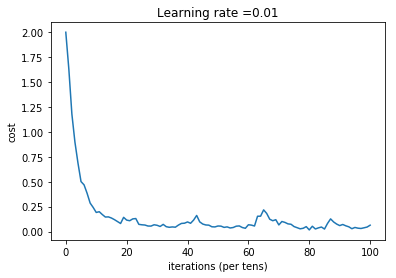

Weights have been optimized!!
Train accuracy: 0.975
Test accuracy: 0.875


In [87]:
parameters = model(X_train, Y_train, X_test, Y_test, batch_size=64, epochs=100, alpha=0.01, verbose=True)

In [88]:
def save_weights(parameters, filename="weights_2.pkl"):
    
    file = os.path.join(os.getcwd(), filename)
    joblib.dump(parameters, file)

In [89]:
save_weights(parameters)